## 客戶流失預測分析報告

在金融產業中，客戶流失對營運造成重大影響。透過資料驅動的分析方法，本研究目標為：

- 預測信用卡客戶是否會流失（Churn）
- 探索與流失相關的重要行為與屬性特徵
- 建立可用於客戶關係管理的預測模型

此研究可協助銀行提升客戶留存率、優化行銷策略並降低營運風險。

【資料集】[BankChurners.csv](https://www.kaggle.com/datasets/sakshigoyal7/credit-card-customers)<br>
【報告成員】711378908吳秉哲、711378912 蔡宜諠<br>

---
---

## <font color=#0000FF>安裝主要的模組</font>

In [2]:
# -*- coding: utf-8 -*-
from platform import python_version
import os, time, glob, socket
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from collections import Counter
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from scipy.stats import chi2_contingency, ttest_ind
import seaborn as sns

print("【日期時間】{}".format(time.strftime("%Y/%m/%d %H:%M:%S")))
print("【工作目錄】{}".format(os.getcwd()))
print("【主機名稱】{} ({})".format(socket.gethostname(),socket.gethostbyname(socket.gethostname())))
print("【Python】{}".format(python_version()))
print("【sklearn】{}".format(sklearn.__version__))

# %autosave 120

【日期時間】2025/05/16 15:32:11
【工作目錄】d:\NTPU_class\ml\code
【主機名稱】MSI (10.20.70.63)
【Python】3.10.5
【sklearn】1.6.1


In [3]:
from matplotlib.font_manager import FontProperties  
winfont01 = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=12) 
winfont02 = FontProperties(fname=r"c:\windows\fonts\kaiu.ttf", size=12) 

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  # 設定字型為微軟正黑體
plt.rcParams['axes.unicode_minus'] = False                # 解決負號顯示問題

macfont = FontProperties(fname="/Library/Fonts/Arial Unicode.ttf", size=10) 

## <font color='blue'>資料讀取</font>

In [5]:
# df = pd.read_csv(r"C:\Data\BankChurners.csv")
n_jobs = int(os.cpu_count()//1.5)
workspace = r"D:\NTPU_class\ml\code"
df = pd.read_csv(fr"{workspace}\PyMLData\BankChurners.csv")
print(df.columns)

Index(['CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender',
       'Dependent_count', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],
      dtype='object')


## <font color='blue'>EDA 檢定: 類別(Chi-Test) / 連續(T-Test)</font>

In [6]:
# 設定應變數: Churn.
df['Churn'] = df['Attrition_Flag'].apply(lambda x: 1 if x == 'Attrited Customer' else 0)
print(df['Churn'].value_counts())
# 類別與連續變數
categorical_vars = ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']
numerical_vars = ['Customer_Age', 'Dependent_count', 'Months_on_book',
                  'Total_Relationship_Count', 'Months_Inactive_12_mon',
                  'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
                  'Avg_Open_To_Buy', 'Total_Trans_Amt', 'Total_Trans_Ct',
                  'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']

# 類別變數卡方檢定
chi_results = {}
for col in categorical_vars:
    table = pd.crosstab(df[col], df['Churn'])
    chi2, p, dof, _ = chi2_contingency(table)
    chi_results[col] = p

# 連續變數 T 檢定
t_test_results = {}
for col in numerical_vars:
    churn_1 = df[df['Churn'] == 1][col]
    churn_0 = df[df['Churn'] == 0][col]
    _, p = ttest_ind(churn_1, churn_0, equal_var=False)
    t_test_results[col] = p

# 結果表格
chi_df = pd.DataFrame(chi_results.items(), columns=["CategoricalVariables", "P-Value"]).sort_values(by="P-Value")
chi_df["P-Value"] = chi_df["P-Value"].round(3)
chi_df['Significantly'] = chi_df['P-Value'].apply(lambda x: "Y" if x <= 0.05 else "N")

ttest_df = pd.DataFrame(t_test_results.items(), columns=["NumericalVariables", "P-Value"]).sort_values(by="P-Value")
ttest_df['P-Value'] = ttest_df['P-Value'].round(3)
ttest_df['Significantly'] = ttest_df['P-Value'].apply(lambda x: "Y" if x <= 0.05 else "N")
print("【Chi-Test】")
print(chi_df)
print("【T-Test】")
print(ttest_df)

Churn
0    8500
1    1627
Name: count, dtype: int64
【Chi-Test】
  CategoricalVariables  P-Value Significantly
0               Gender    0.000             Y
3      Income_Category    0.025             Y
1      Education_Level    0.051             N
2       Marital_Status    0.109             N
4        Card_Category    0.525             N
【T-Test】
          NumericalVariables  P-Value Significantly
10            Total_Trans_Ct    0.000             Y
11       Total_Ct_Chng_Q4_Q1    0.000             Y
7        Total_Revolving_Bal    0.000             Y
9            Total_Trans_Amt    0.000             Y
5      Contacts_Count_12_mon    0.000             Y
12     Avg_Utilization_Ratio    0.000             Y
4     Months_Inactive_12_mon    0.000             Y
3   Total_Relationship_Count    0.000             Y
6               Credit_Limit    0.016             Y
1            Dependent_count    0.053             N
0               Customer_Age    0.058             N
2             Months_on_book

## <font color='blue'>EDA 圖表繪製: 類別(百分比堆疊圖) / 連續(盒狀圖)</font>

In [7]:
cat_list = chi_df[chi_df['Significantly'] == 'Y']['CategoricalVariables'].to_list()
num_list = ttest_df[ttest_df['Significantly'] == 'Y']['NumericalVariables'].to_list()

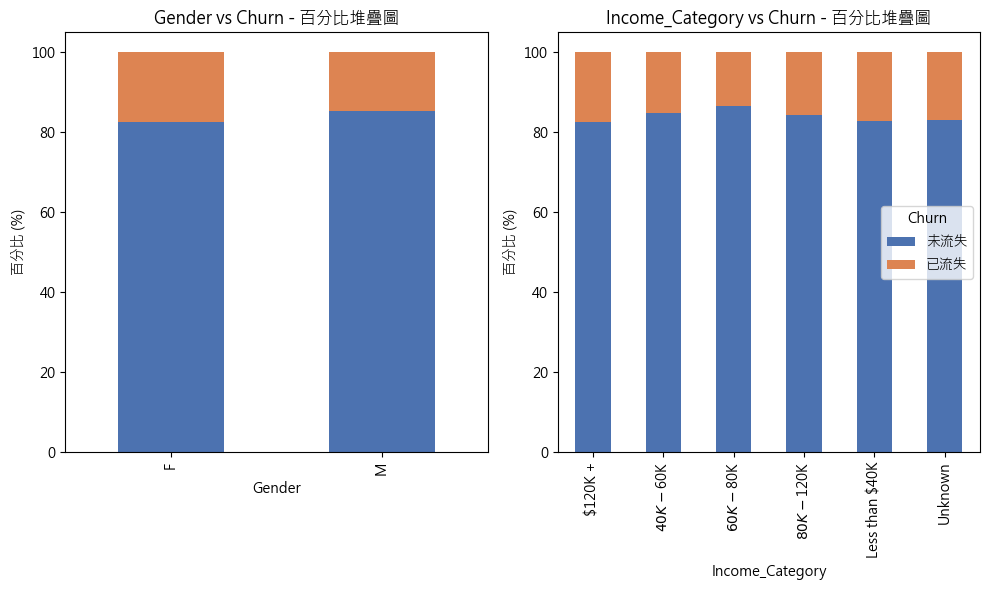

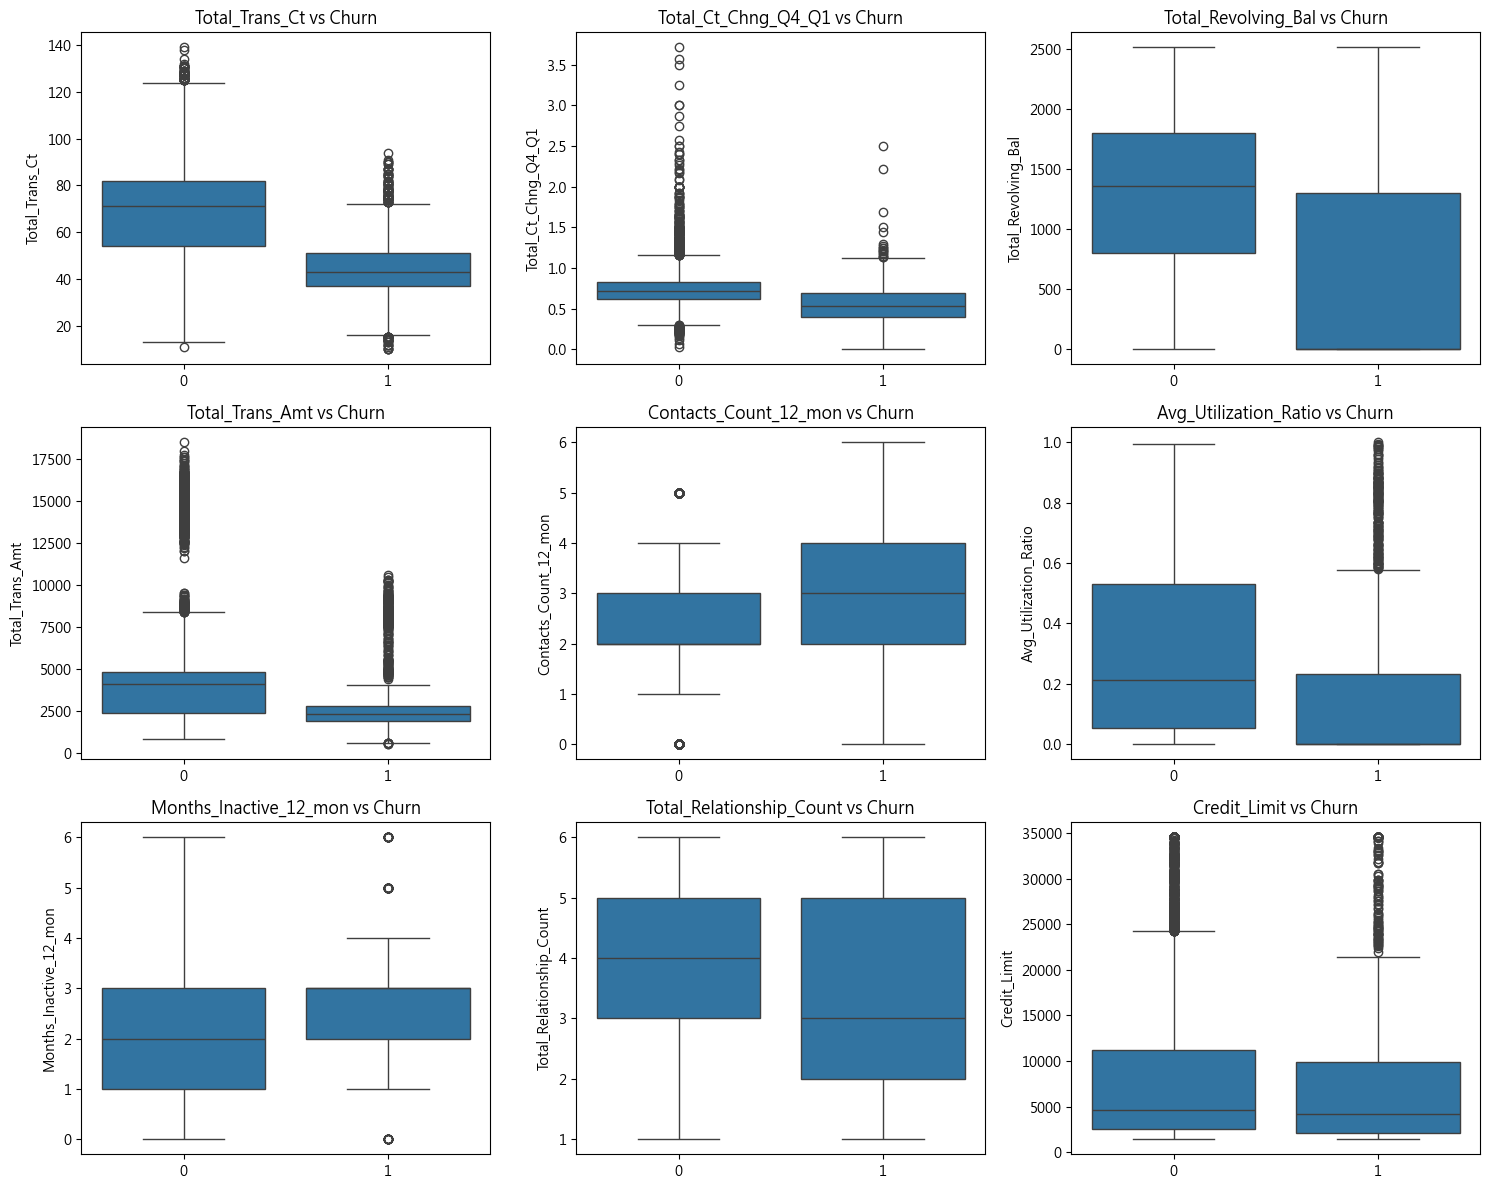

In [8]:
cat_list = chi_df[chi_df['Significantly'] == 'Y']['CategoricalVariables'].to_list()
num_list = ttest_df[ttest_df['Significantly'] == 'Y']['NumericalVariables'].to_list()

# 顏色對應 Churn: 0=藍, 1=橘
color_map = {0: '#4c72b0', 1: '#dd8452'}

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))  # 調整高度方便閱讀

for idx, col in enumerate(cat_list):
    crosstab = pd.crosstab(df[col], df['Churn'], normalize='index') * 100
    crosstab = crosstab[[0, 1]]  # 確保順序
    crosstab.plot(kind='bar', stacked=True,
                  color=[color_map[0], color_map[1]],
                  ax=axs[idx],
                  legend=False)  # 避免重複圖例
    plt.legend(title='Churn', labels=['未流失', '已流失'], loc='center right')
    axs[idx].set_title(f'{col} vs Churn - 百分比堆疊圖')
    axs[idx].set_ylabel('百分比 (%)')

# 單獨設定圖例於最後
handles, labels = axs[0].get_legend_handles_labels()


plt.tight_layout()
plt.show()

# 建立 3x3 子圖
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
axs = axs.flatten()  # 攤平成一維 list 方便索引

# 連續變數盒狀圖
for i, col in enumerate(num_list):
    sns.boxplot(data=df, x='Churn', y=col, ax=axs[i])
    axs[i].set_title(f'{col} vs Churn')
    axs[i].set_xlabel('')  # 可以視情況隱藏標籤
    axs[i].set_ylabel(col)

# 排版美化
plt.tight_layout()
plt.show()

## <font color='blue'>資料清洗: 類別(One-Hot Encoding) / 連續(MixMaxScaler)</font>

In [9]:
# 篩選是否顯著
# Label
y = df["Churn"].to_numpy()

# 類別 Features
X_categorical_sig = pd.get_dummies(df[cat_list],
                                   drop_first=False, # One-Hot encoding
                                   dtype=np.int16)
# 連續 Features
scaler = MinMaxScaler()  # 標準化X 的單位, 可用來比較變數重要度.
X_numerical_sig = pd.DataFrame(scaler.fit_transform(df[num_list]), 
                               columns=num_list)


# 合併 Features
pd_X_std_sig = pd.concat([X_categorical_sig, X_numerical_sig], axis=1)
X_std_sig = pd_X_std_sig.to_numpy()

print(X_categorical_sig.shape)
print(X_numerical_sig.shape)
print(X_std_sig.shape)

(10127, 8)
(10127, 9)
(10127, 17)


In [10]:
# 全部變數都放下去
# Label
y = df["Churn"].to_numpy()

# 類別 Features
X_categorical = pd.get_dummies(df[categorical_vars],
                                drop_first=False, # One-Hot encoding
                                dtype=np.int16)
# 連續 Features
scaler = MinMaxScaler()  # 標準化X 的單位, 可用來比較變數重要度.
X_numerical = pd.DataFrame(scaler.fit_transform(df[numerical_vars]), 
                           columns=numerical_vars)

# 合併 Features
pd_X_std = pd.concat([X_categorical, X_numerical], axis=1)
X_std = pd_X_std.to_numpy()

print(X_categorical.shape)
print(X_numerical.shape)
print(X_std.shape)

(10127, 23)
(10127, 13)
(10127, 36)


## <font color='blue'>模型實驗</font>

#### 切割資料

In [14]:
# 篩選是否顯著
from sklearn.model_selection import train_test_split
def train_test_split_with_feature_selection(significant_feature, random_state=42, verbose=False):
    if significant_feature == 'significant_features':
        _X_std = X_std_sig
    elif significant_feature == 'all_features':
        _X_std = X_std
    else:
        raise ValueError("Invalid value for significant_feature. Please choose 'significant' or 'all_features'.")
    
    # 切一下訓練 & 測試集
    X_train, X_test, y_train, y_test = train_test_split(
        _X_std, y, 
        test_size=0.2, 
        random_state=random_state,
        stratify=y)  # 分層抽樣
    
    if verbose: 
        shapes = {
            'X': [X_train.shape, X_test.shape],
            'y': [y_train.shape, y_test.shape]
        }

        # 將數據轉換為 pandas DataFrame
        shape_df = pd.DataFrame(shapes, index=['訓練集', '測試集'])
        print("【切割後 X y 的 shape】")
        print(shape_df)
        print("========================")
        print(Counter(y_train)) 
        print(Counter(y_test))
    return X_train, X_test, y_train, y_test

In [15]:
X_train, X_test, y_train, y_test = train_test_split_with_feature_selection('all_features', verbose=True)

【切割後 X y 的 shape】
              X        y
訓練集  (8101, 36)  (8101,)
測試集  (2026, 36)  (2026,)
Counter({np.int64(0): 6799, np.int64(1): 1302})
Counter({np.int64(0): 1701, np.int64(1): 325})


資料看起來很不平衡 不知道做了資料不平衡會不會比較好 <br>
所以都做 留下原始的資料原始的資料 也有一份處理過資料不平衡的

---

#### 處理資料不平衡

In [17]:
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
# 先封裝起來備用
class DataImbalanceHandler:
    def __init__(self, X, y, verbose=False):
        self.X = X
        self.y = y
        self.verbose = verbose  # 控制是否顯示詳細輸出

    def smote(self):
        # 過採樣(SMOTE)處理資料不平衡。
        smote = SMOTE(
            sampling_strategy='auto',   # 抽樣的策略
            random_state=None,          # seed
            k_neighbors=5)              # k 鄰近幾個點
        X_res, y_res = smote.fit_resample(self.X, self.y)
        print("   > SMOTE over-sampling applied.") if self.verbose else None
        return X_res, y_res

    def undersample(self):
        # 欠採樣(Random Under-Sampling)處理資料不平衡。
        undersample = RandomUnderSampler(
            random_state=42)
        X_res, y_res = undersample.fit_resample(self.X, self.y)
        print("   > Random under-sampling applied.") if self.verbose else None
        return X_res, y_res

    def smoteenn(self):
        # SMOTE + ENN(Edited Nearest Neighbours)處理資料不平衡。
        smote_enn = SMOTEENN(
            sampling_strategy='auto',     # 抽樣策略
            random_state=None,            # seed
            smote=None,                   # 如果給none就是預設值 - SMOTE(sampling_strategy='auto', random_state=None, k_neighbors=5)
            n_jobs=n_jobs)                   # n_jobs : 使用的 CPU 的核心數
        X_res, y_res = smote_enn.fit_resample(self.X, self.y)
        print("   > SMOTE + ENN applied.") if self.verbose else None
        return X_res, y_res

    def smotetomek(self):
        # SMOTE + Tomek Links(用於消除邊界噪音)處理資料不平衡。
        smote_tomek = SMOTETomek(
            sampling_strategy='auto',     # 抽樣策略
            random_state=None,            # seed
            smote=None,                   # SMOTE(sampling_strategy='auto', random_state=None, k_neighbors=5)
            tomek=None,                   # EditedNearestNeighbours(sampling_strategy='auto', n_neighbors=3, kind_sel='all', n_jobs=None)
            n_jobs=n_jobs)                   # n_jobs : 使用的 CPU 的核心數
        X_res, y_res = smote_tomek.fit_resample(self.X, self.y)
        print("   > SMOTE + Tomek Links applied.") if self.verbose else None
        return X_res, y_res
        

    def handle_imbalance(self, method='none'):
        """
        Parameters:
        method : str
            處理資料不平衡，選擇處理方法: 
            - 'none': 不進行資料處理
            - 'smote': 過採樣(SMOTE)
            - 'undersample': 欠採樣(RandomUnderSampler)
            - 'smoteenn': SMOTE + ENN
            - 'smotetomek': SMOTE + Tomek Links

        Returns:
        X_res, y_res : 處理後的特徵和標籤
        """
        print("\n[ 資料預處理 - 處理資料不平衡 ]") if self.verbose else None
        start_time = time.time()  # 記錄開始時間
        
        if method == 'smote':
            X_res, y_res = self.smote()
        elif method == 'undersample':
            X_res, y_res = self.undersample()
        elif method == 'smoteenn':
            X_res, y_res = self.smoteenn()
        elif method == 'smotetomek':
            X_res, y_res = self.smotetomek()
        else:
            print("   > No imbalance handling applied.") if self.verbose else None
            return self.X, self.y
        
        end_time = time.time()    # 記錄結束時間並計算執行時間
        elapsed_time = end_time - start_time
        
        print(f"   > 【Original】: {Counter(self.y)}") if self.verbose else None
        print(f"   > 【After {method}】: {Counter(y_res)}") if self.verbose else None
        print(f"   > Time taken for {method}: {elapsed_time:.2f} seconds") if self.verbose else None
        return X_res, y_res

In [18]:
# 稍微看一下他會長成甚麼樣子
imbalance_handler = DataImbalanceHandler(X_train, y_train, verbose=True)
X_res, y_res = imbalance_handler.handle_imbalance(method='smote')
# 有些會沒辦法抽到太遠的地方去
# 這裡欄位太多 不太能可視化


[ 資料預處理 - 處理資料不平衡 ]
   > SMOTE over-sampling applied.
   > 【Original】: Counter({np.int64(0): 6799, np.int64(1): 1302})
   > 【After smote】: Counter({np.int64(0): 6799, np.int64(1): 6799})
   > Time taken for smote: 0.30 seconds


---

#### 模型設定

In [19]:
# 模型初始化
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

class ModelFactory:
    def __init__(self, verbose=False):
        self.verbose = verbose  # 控制是否顯示詳細輸出

    def logistic_regression(self):
        # Logistic Regression 模型。
        model = LogisticRegression(penalty='l2',           # 懲罰項
                                   dual=False,
                                   tol=0.0001,             # tolerence 容忍門檻值
                                   max_iter=1000,           # 迭代次數(跑幾次)
                                   C=1.0,                  # lambda 值
                                   random_state=None,      # seed
                                   solver='lbfgs',         # 最佳化器
                                #    multi_class='auto',     # 版本 1.5 中消失了
                                   verbose=0,              # 顯示訊息量的多寡
                                   warm_start=False, 
                                   n_jobs=n_jobs)               # cores 電腦 cpu 的核心數
        return model

    def knn_classifier(self, n_neighbors=5):
        # K-Nearest Neighbors Classifier 模型。
        model = KNeighborsClassifier(n_neighbors=n_neighbors,  # kNN 的 k
                                     weights='uniform',
                                     p=2,                      # p=2 : euclidean_distance
                                     metric='minkowski',
                                     n_jobs=n_jobs)
        return model

    def decision_tree_classifier(self, max_depth=None):
        # Decision Tree Classifier 模型。
        model = DecisionTreeClassifier(criterion='gini',         # gini : CART, entropy : C4.5/C5.0
                                       max_depth=max_depth)
        return model

    def random_forest_classifier(self, **kwargs):
        # Random Forest Classifier 模型。
        default_params = {
            'n_estimators': 100,
            'max_depth': None,
            'random_state': 42 
        }
        default_params.update(kwargs)
        model = RandomForestClassifier(**default_params)
        return model

    def gaussian_nb(self):
        # 返回 Gaussian Naive Bayes 模型。
        model = GaussianNB()
        return model
    
    
    def create_and_train_model(self, model_name, __X_train, __y_train, **kwargs):
        """
        Parameters:
        model_name : str
            模型名稱，選項包括：'Logistic Regression', 'K-Nearest Neighbors', 'Decision Tree', 'Gaussian Naive Bayes'
        X_train : Features data (ndarray 或 DataFrame)
        y_train : Target labels data (ndarray 或 DataFrame)
        kwargs : dict
            模型的超參數

        Returns:
        model : 訓練好的模型
        """
        start_time = time.time()

        if model_name == 'Logistic Regression':
            model = self.logistic_regression()
        elif model_name == 'K-Nearest Neighbors':
            model = self.knn_classifier(**kwargs)
        elif model_name == 'Decision Tree':
            model = self.decision_tree_classifier()
        elif model_name == 'Gaussian Naive Bayes':
            model = self.gaussian_nb()
        elif model_name == 'Random Forest':
            model = self.random_forest_classifier(**kwargs)
        else:
            print(f"Model {model_name} is not recognized.") if self.verbose else None
            return None
        print("[ 訓練模型開始 ]") if self.verbose else None
        print(f"【{model_name}】") if self.verbose else None
        model.fit(__X_train, __y_train)
        end_time = time.time() 
        elapsed_time = end_time - start_time
        print(f"   > Time taken for {model_name} factory: {elapsed_time:.2f} seconds.") if self.verbose else None
        
        return model

In [20]:
# 評估且觀察一下模型
import time
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import f1_score
from tabulate import tabulate

class ModelTraining:
    def __init__(self, __X_train, __y_train, __X_test, __y_test, model_factory, verbose=False):
        self.X_train = __X_train
        self.y_train = __y_train
        self.X_test = __X_test
        self.y_test = __y_test
        self.model_factory = model_factory  # 使用 ModelFactory 類別創建模型
        self.verbose = verbose  # 控制是否顯示詳細輸出
    
    def cross_validation(self, model):
        cv = RepeatedStratifiedKFold(n_splits=5,            # k-fold 的 k
                                     n_repeats=30,          # 外面迴圈的次數
                                     random_state=None)# 這裡如果設定數值的話每一次都會跑一樣ㄉ 所以不能給她一樣的     

        # 计算 accuracy 和 F1 分数
        accuracy_scores = cross_val_score(estimator=model,
                                          X=self.X_train, y=self.y_train,
                                          scoring="accuracy",  # 计算 accuracy
                                          cv=cv, n_jobs=n_jobs, verbose=0)
        
        f1_scores = cross_val_score(estimator=model,
                                     X=self.X_train, y=self.y_train,
                                     scoring="f1",  # 计算 f1 score
                                     cv=cv, n_jobs=n_jobs, verbose=0)
        
        # 返回 accuracy 和 f1 的均值和标准差
        return np.mean(accuracy_scores), np.std(accuracy_scores), np.mean(f1_scores), np.std(f1_scores)
    
    def confusion_matrix(self, model):
        y_train_pred = model.predict(self.X_train)
        y_test_pred = model.predict(self.X_test)

        train_conf_matrix = confusion_matrix(self.y_train, y_train_pred)
        test_conf_matrix = confusion_matrix(self.y_test, y_test_pred)
        train_conf_matrix_df = pd.DataFrame(train_conf_matrix, index=['True 0', 'True 1'], columns=['Pred 0', 'Pred 1'])
        test_conf_matrix_df = pd.DataFrame(test_conf_matrix, index=['True 0', 'True 1'], columns=['Pred 0', 'Pred 1'])
        report_dict = classification_report(self.y_test, y_test_pred, output_dict=True)
        df_classification_report = pd.DataFrame(report_dict).transpose().round(3)

        return train_conf_matrix_df, test_conf_matrix_df, df_classification_report

    def evaluate(self, model):
        # 評估模型的性能，包括準確度、分類報告和混淆矩陣。
        y_pred = model.predict(self.X_test)
        accuracy = accuracy_score(self.y_test, y_pred)
        train_accuracy = model.score(self.X_train, self.y_train)
        test_accuracy = model.score(self.X_test, self.y_test)
        train_f1 = f1_score(self.y_train, model.predict(self.X_train), average='binary')
        test_f1 = f1_score(self.y_test, y_pred, average='binary')
        cv_acc_mean, cv_acc_std, cv_f1_mean, cv_f1_std = self.cross_validation(model)

        if self.verbose:
            print(f"   > train acc : {train_accuracy:.2%}")
            print(f"   > test acc : {test_accuracy:.2%}")
            print(f"   > train f1 : {train_f1:.2%}")
            print(f"   > test f1 : {test_f1:.2%}")
            print(f"   > cv_acc_mean : {cv_acc_mean:.2f}")
            print(f"   > cv_acc_std : {cv_acc_std:.2f}")
            print(f"   > cv_f1_mean : {cv_f1_mean:.2f}")
            print(f"   > cv_f1_std : {cv_f1_std:.2f}")
            print(f"   > 準確度 Accuracy: {accuracy:.4f}")

        res = {
            'accuracy': accuracy,
            'train_accuracy': train_accuracy,
            'test_accuracy': test_accuracy,
            'train_f1': train_f1,
            'test_f1': test_f1,
            'cv_acc_mean': cv_acc_mean,
            'cv_acc_std': cv_acc_std,
            'cv_f1_mean': cv_f1_mean,
            'cv_f1_std': cv_f1_std,
            # 'classification_report': classification_report(self.y_test, y_pred),
            # 'confusion_matrix': confusion_matrix(self.y_test, y_pred)
        }
        return res

    def run(self, model_name, **kwargs):
        """
        訓練並評估模型。

        Parameters:
        model_name : str
            模型的名稱，選項包括：'Random Forest', 'Logistic Regression', 'K-Nearest Neighbors', 'Decision Tree', 'Gaussian Naive Bayes'
        kwargs : dict
            用來設置模型的超參數
        """
        start_time = time.time()
        model = self.model_factory.create_and_train_model(model_name, self.X_train, self.y_train, **kwargs)
        model_results = None
        if model is not None:
            model_results = self.evaluate(model)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"   > Time taken for {model_name} evaluate: {elapsed_time:.2f} seconds.") if self.verbose else None
        
        return model_results

In [21]:
model_factory = ModelFactory(verbose=False)  # 創建 ModelFactory 實例
model_training = ModelTraining(X_train, y_train, X_test, y_test, model_factory, verbose=True)  # 傳入 ModelFactory 實例
model_results = model_training.run("Logistic Regression")

   > train acc : 90.66%
   > test acc : 89.93%
   > train f1 : 65.51%
   > test f1 : 61.36%
   > cv_acc_mean : 0.90
   > cv_acc_std : 0.01
   > cv_f1_mean : 0.64
   > cv_f1_std : 0.02
   > 準確度 Accuracy: 0.8993
   > Time taken for Logistic Regression evaluate: 5.24 seconds.


---

#### main：

In [18]:
# 讓大家跑起來ㄅ
def process_combination(_X_train, _X_test, _y_train, _y_test, imbalance_method, model, verbose=False):
    start_time = time.time()
    print(f"✅資料不平衡處理方法: {imbalance_method}") if verbose else None
    
    # 資料不平衡處理
    imbalance_handler = DataImbalanceHandler(_X_train, _y_train, verbose=verbose)
    X_train_res, y_train_res = imbalance_handler.handle_imbalance(method=imbalance_method)

    model_factory = ModelFactory(verbose=verbose)  # 創建 ModelFactory 實例
    # 模型訓練與評估
    model_training = ModelTraining(X_train_res, y_train_res, _X_test, _y_test, model_factory, verbose=verbose)

    print(f"Training {model}...") if verbose else None
    model_results = model_training.run(model)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"   > Time taken for {imbalance_method, model} evaluate: {elapsed_time:.2f} seconds.") if verbose else None
    return model_results, elapsed_time

In [ ]:
# [ main ]
# 這個會跑大概2m2s建議不要跑 
significant_features = ['all_features']                                                                             # 看看有沒有顯著: 'significant_features', 'all_features'
imbalance_methods = ['none', 'smote']                                                                               # 可選的資料不平衡處理方法: 'none', 'smote', 'undersample', 'smoteenn', 'smotetomek'
models = ['Logistic Regression', 'K-Nearest Neighbors', 'Decision Tree', 'Gaussian Naive Bayes', 'Random Forest']   # 可選的模型
feature_names = pd_X_std.columns
    

# 最後比較所有組合結果
results_list = []

for random_state in range(100):
    for significant_feature in significant_features:
        for imbalance_method in imbalance_methods:
            for model in models:
                X_train, X_test, y_train, y_test = train_test_split_with_feature_selection(significant_feature, random_state=random_state, verbose=False)
                model_results, elapsed_time = process_combination(X_train, X_test, y_train, y_test, imbalance_method, model, verbose=False)
                # print(model_results)
                results_list.append({
                    'random_state_index': random_state,
                    'imbalance_method': imbalance_method,
                    'significant_feature': significant_feature,
                    'model': model,
                    'elapsed_time': elapsed_time,
                    # 'accuracy': model_results['accuracy'],    # 有的模型跟跟test_accuracy 是一樣的
                    'train_accuracy': model_results['train_accuracy'],
                    'test_accuracy': model_results['test_accuracy'],
                    'train_f1': model_results['train_f1'],
                    'test_f1': model_results['test_f1'],
                    'cv_acc_mean': model_results['cv_acc_mean'],
                    'cv_acc_std': model_results['cv_acc_std'],
                    'cv_f1_mean': model_results['cv_f1_mean'],
                    'cv_f1_std': model_results['cv_f1_std'],
                })

results_df = pd.DataFrame(results_list)
results_df.to_csv(fr"{workspace}\model_result_0510.csv", index=False)

#### 調整參數

In [22]:
_X_train, _X_test, _y_train, _y_test = train_test_split_with_feature_selection('all_features', random_state=42, verbose=True)

【切割後 X y 的 shape】
              X        y
訓練集  (8101, 36)  (8101,)
測試集  (2026, 36)  (2026,)
Counter({np.int64(0): 6799, np.int64(1): 1302})
Counter({np.int64(0): 1701, np.int64(1): 325})


In [ ]:
# 這要跑超久不建議跑
_verbose = False
_model_name = 'Random Forest'
_max_depth = 5 # 5-10
_leaf = 2 # 1-5
_split = 2# 2-10

results_list = []
for _max_depth in range(5, 11):  # 5-10
    for _leaf in range(1, 6):  # 1-5
        for _split in range(2, 11): # 2-10
            start_time = time.time()
            _model_factory = ModelFactory(verbose=_verbose)
            model = _model_factory.create_and_train_model(
                _model_name, _X_train, _y_train,
                max_depth=_max_depth,
                min_samples_split=_split,
                min_samples_leaf=_leaf,
            )
            model_training = ModelTraining(_X_train, _y_train, _X_test, _y_test, model_factory=None, verbose=_verbose)
            model_results = model_training.evaluate(model)
            end_time = time.time()
            elapsed_time = end_time - start_time

            results_list.append({
                    'max_depth': _max_depth,
                    'min_samples_split': _split,
                    'min_samples_leaf': _leaf,
                    'elapsed_time': elapsed_time,
                    # 'accuracy': model_results['accuracy'],    # 有的模型跟跟test_accuracy 是一樣的
                    'train_accuracy': model_results['train_accuracy'],
                    'test_accuracy': model_results['test_accuracy'],
                    'train_f1': model_results['train_f1'],
                    'test_f1': model_results['test_f1'],
                    'cv_acc_mean': model_results['cv_acc_mean'],
                    'cv_acc_std': model_results['cv_acc_std'],
                    'cv_f1_mean': model_results['cv_f1_mean'],
                    'cv_f1_std': model_results['cv_f1_std'],
                })



results_rf_df = pd.DataFrame(results_list)
results_rf_df.to_csv(fr"{workspace}\model_result_rf_0510.csv", index=False)

## 📈Summary

##### ✅實驗結果總覽

In [94]:
from tabulate import tabulate
results_df = pd.read_csv(fr"{workspace}\model_result_0510.csv")
_results_df = results_df.groupby(['imbalance_method', 'model']).agg({'test_accuracy': 'mean', 'test_f1': 'mean', 'train_accuracy': 'mean', 'train_f1': 'mean','cv_acc_mean': 'mean', 'cv_f1_mean': 'mean', 'elapsed_time':'mean'}).reset_index()
_results_df[['test_accuracy', 'test_f1', 'train_accuracy', 'train_f1', 'cv_acc_mean', 'cv_f1_mean', 'elapsed_time']] = _results_df[['test_accuracy', 'test_f1', 'train_accuracy', 'train_f1', 'cv_acc_mean', 'cv_f1_mean', 'elapsed_time']].round(3)
pd_model_result_sorted = _results_df.sort_values(by=['test_accuracy', 'test_f1', 'cv_acc_mean', 'cv_f1_mean'], ascending=[False, False, False, False]).reset_index(drop=True)
pd_model_result_sorted = pd_model_result_sorted.reindex(columns=["imbalance_method", "model", "train_accuracy", "train_f1", "test_accuracy", "test_f1", "cv_acc_mean", "cv_f1_mean", "elapsed_time"])

# 大概看一下所有的排行
top_3_acc = _results_df.nlargest(3, 'test_accuracy').reset_index(drop=True)
top_3_f1 = _results_df.nlargest(3, 'test_f1').reset_index(drop=True)
top_3_cv_acc = _results_df.nlargest(3, 'cv_acc_mean').reset_index(drop=True)
top_3_cv_f1 = _results_df.nlargest(3, 'cv_f1_mean').reset_index(drop=True)

print(f"Top 3 models by accuracy:")
print(tabulate(top_3_acc, headers='keys', tablefmt='pretty', showindex=False))
print(f"\nTop 3 models by F1 score:")
print(tabulate(top_3_f1, headers='keys', tablefmt='pretty', showindex=False))
print(f"Top 3 models by cv_acc_mean:")
print(tabulate(top_3_cv_acc, headers='keys', tablefmt='pretty', showindex=False))
print(f"Top 3 models by cv_f1_mean:")
print(tabulate(top_3_cv_f1, headers='keys', tablefmt='pretty', showindex=False))

Top 3 models by accuracy:
+------------------+---------------+---------------+---------+----------------+----------+-------------+------------+--------------+
| imbalance_method |     model     | test_accuracy | test_f1 | train_accuracy | train_f1 | cv_acc_mean | cv_f1_mean | elapsed_time |
+------------------+---------------+---------------+---------+----------------+----------+-------------+------------+--------------+
|       none       | Random Forest |     0.953     |  0.84   |      1.0       |   1.0    |    0.951    |   0.832    |    31.982    |
|      smote       | Random Forest |     0.951     |  0.847  |      1.0       |   1.0    |    0.973    |   0.973    |    60.42     |
|       none       | Decision Tree |     0.934     |  0.793  |      1.0       |   1.0    |    0.932    |   0.787    |    2.227     |
+------------------+---------------+---------------+---------+----------------+----------+-------------+------------+--------------+

Top 3 models by F1 score:
+---------------

##### ✅處理資料不平衡- SMOTE

In [45]:
_verbose = True
_imbalance_method = 'smote'

_X_train, _X_test, _y_train, _y_test = train_test_split_with_feature_selection('all_features', random_state=43, verbose=True)
# 資料不平衡處理
imbalance_handler = DataImbalanceHandler(_X_train, _y_train, verbose=_verbose)
X_train_res, y_train_res = imbalance_handler.handle_imbalance(method=_imbalance_method)
X_train_res_df = pd.DataFrame(X_train_res, columns=pd_X_std.columns)  # 確保列名對應原本的 X_train
y_train_res_df = pd.DataFrame(y_train_res, columns=['Churn'])
X_train_combined = pd.concat([X_train_res_df, y_train_res_df], axis=1)

【切割後 X y 的 shape】
              X        y
訓練集  (8101, 36)  (8101,)
測試集  (2026, 36)  (2026,)
Counter({np.int64(0): 6799, np.int64(1): 1302})
Counter({np.int64(0): 1701, np.int64(1): 325})

[ 資料預處理 - 處理資料不平衡 ]
   > SMOTE over-sampling applied.
   > 【Original】: Counter({np.int64(0): 6799, np.int64(1): 1302})
   > 【After smote】: Counter({np.int64(0): 6799, np.int64(1): 6799})
   > Time taken for smote: 0.08 seconds


C:\Users\USER\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\USER\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\USER\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 36039 (\N{CJK UNIFIED IDEOGRAPH-8CC7}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\USER\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26009 (\N{CJK UNIFIED IDEOGRAPH-6599}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\USER\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152:

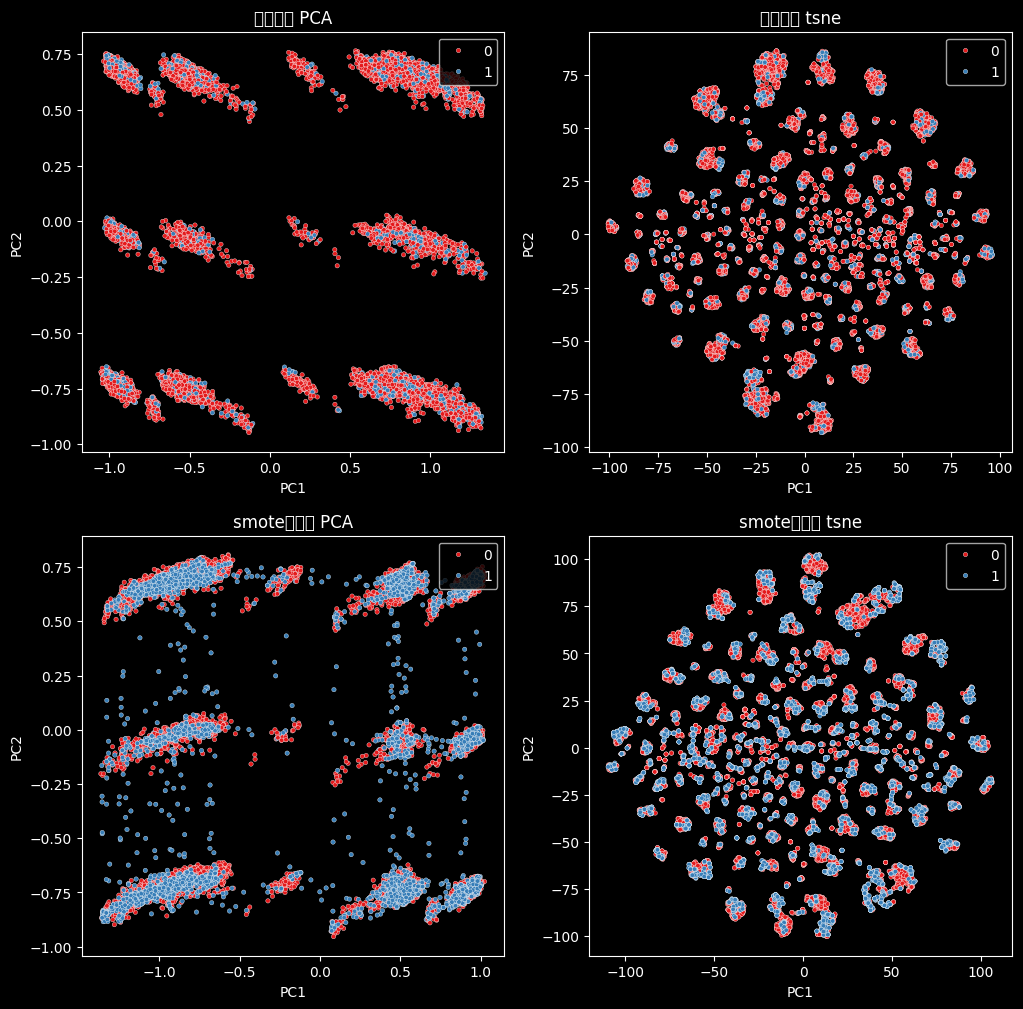

In [ ]:
# PCA 圖看一下
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
plt.style.use('dark_background')

plt.figure(figsize=(12, 12))
# 原始資料 pca
plt.subplot(2, 2, 1)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(pd_X_std)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df["Churn"].to_numpy(), palette='Set1', s=10)
plt.title("原始資料 PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(loc='upper right')

# 原始資料 TSNE
plt.subplot(2, 2, 2)
tsne = TSNE(
    n_components=2,    # 降維幾維
    max_iter=1000,       # 跌代次數
)
X_tsne = tsne.fit_transform(pd_X_std)
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=df["Churn"].to_numpy(), palette='Set1', s=10)
plt.title("原始資料 tsne")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(loc='upper right')

# 處理資料不平衡 pca
plt.subplot(2, 2, 3)
pca = PCA(n_components=2)
X_pca_smote = pca.fit_transform(X_train_combined.drop(columns=['Churn']))
sns.scatterplot(x=X_pca_smote[:, 0], y=X_pca_smote[:, 1], hue=X_train_combined['Churn'], palette='Set1', s=10)
plt.title("smote後資料 PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(loc='upper right')

# 處理資料不平衡 TSNE
plt.subplot(2, 2, 4)
tsne = TSNE(
    n_components=2,    # 降維幾維
    max_iter=1000,       # 跌代次數
)
X_tsne_smote = tsne.fit_transform(X_train_combined.drop(columns=['Churn']))
sns.scatterplot(x=X_tsne_smote[:, 0], y=X_tsne_smote[:, 1], hue=X_train_combined['Churn'], palette='Set1', s=10)
plt.title("smote後資料 tsne")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(loc='upper right')
plt.show()

##### ✅模型訓練與評估- RF

In [135]:
from tabulate import tabulate
# 模型訓練與評估
_verbose = True
_model = 'Random Forest'
_model_factory = ModelFactory(verbose=_verbose).create_and_train_model(_model, _X_train, _y_train)  # 創建 ModelFactory 實例
print(_model_factory.__class__.__name__)

# 檢查隨機森林的每棵樹的深度
_model_train = ModelTraining(X_train_res, y_train_res, _X_test, _y_test, None, verbose=_verbose)
model_results = _model_train.evaluate(_model_factory)
train_conf_matrix_df, test_conf_matrix_df, df_classification_report = _model_train.confusion_matrix(_model_factory)
print("==================================")
# 顯示混淆矩陣表格
print("Train Confusion Matrix:")
print(tabulate(train_conf_matrix_df))

print("\nTest Confusion Matrix:")
print(tabulate(test_conf_matrix_df))

print("\nTest classification report:")
print(tabulate(df_classification_report))

[ 訓練模型開始 ]
【Random Forest】
   > Time taken for Random Forest factory: 1.12 seconds.
RandomForestClassifier
   > train acc : 93.40%
   > test acc : 95.26%
   > train f1 : 92.94%
   > test f1 : 83.95%
   > cv_acc_mean : 0.97
   > cv_acc_std : 0.00
   > cv_f1_mean : 0.97
   > cv_f1_std : 0.00
   > 準確度 Accuracy: 0.9526
Train Confusion Matrix:
------  ----  ----
True 0  6799     0
True 1   897  5902
------  ----  ----

Test Confusion Matrix:
------  ----  ---
True 0  1679   22
True 1    74  251
------  ----  ---

Test classification report:
------------  -----  -----  -----  --------
0             0.958  0.987  0.972  1701
1             0.919  0.772  0.839   325
accuracy      0.953  0.953  0.953     0.953
macro avg     0.939  0.88   0.906  2026
weighted avg  0.952  0.953  0.951  2026
------------  -----  -----  -----  --------


RandomForestClassifier


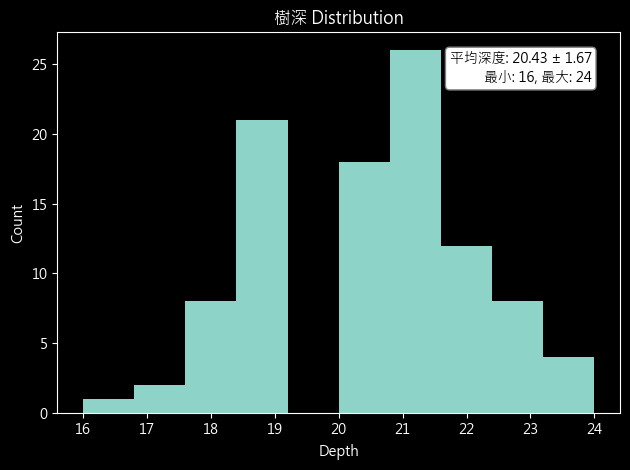

In [134]:
print(_model_factory.__class__.__name__)
max_depths = [tree.get_depth() for tree in _model_factory.estimators_]
mean_depth = np.mean(max_depths)
std_depth = np.std(max_depths)
min_depth = np.min(max_depths)
max_depth = np.max(max_depths)

plt.hist(max_depths, bins=10)
plt.title("樹深 Distribution")
plt.xlabel("Depth")
plt.ylabel("Count")
text = f"平均深度: {mean_depth:.2f} ± {std_depth:.2f}\n最小: {min_depth}, 最大: {max_depth}"
plt.text(0.95, 0.95, text,
         transform=plt.gca().transAxes,
         fontsize=10,
         verticalalignment='top',
         horizontalalignment='right',
         color='black',  # ← 這裡改色
         bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round'))

plt.tight_layout()
plt.show()

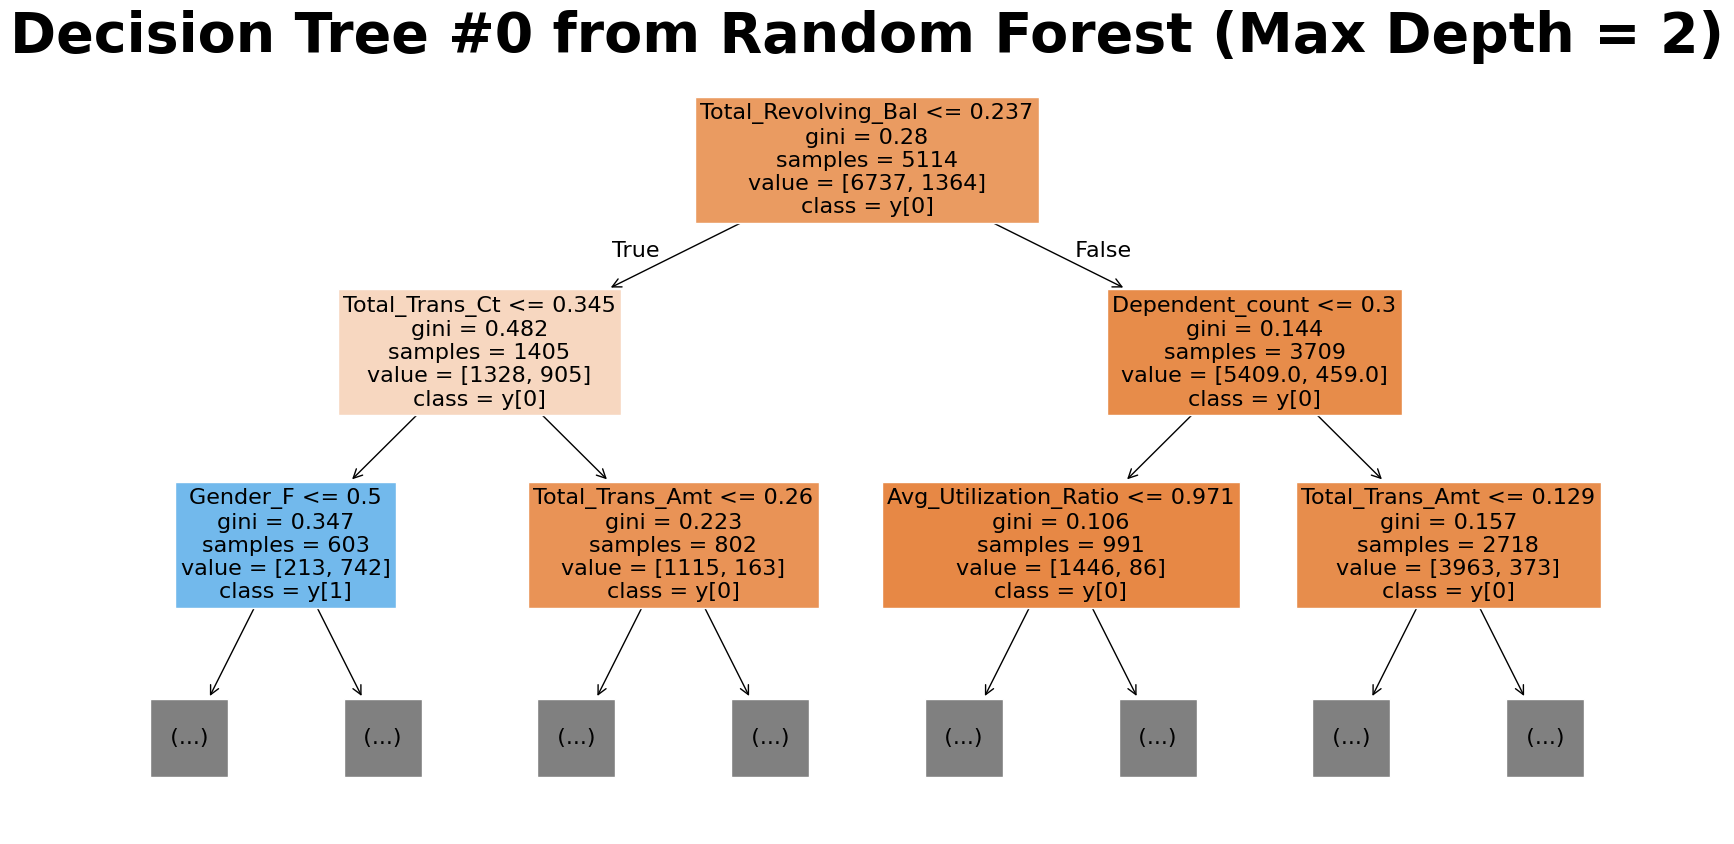

In [40]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('default')
matplotlib.rcParams['text.color'] = 'black'
matplotlib.rcParams['lines.color'] = 'white'
matplotlib.rcParams['patch.edgecolor'] = 'white'

# 選擇第 0 棵決策樹（也可以改成 1、2...）
estimator = _model_factory.estimators_[0]

plt.figure(figsize=(20, 10))
plot_tree(estimator, 
          feature_names=pd_X_std.columns,  # 替換成你的欄位名稱
          class_names=True, 
          filled=True,
          rounded=False,
          max_depth=2, # 只畫前三層
          fontsize=16) 
plt.title("Decision Tree #0 from Random Forest (Max Depth = 2)", fontsize=40, weight='bold')  # ← 加上標題
plt.show()

 Ater: Counter({np.int64(0): 6799, np.int64(1): 1302})
RandomForestClassifier
 Ater: Counter({np.int64(0): 6799, np.int64(1): 6799})
RandomForestClassifier
 Ater: Counter({np.int64(0): 6799, np.int64(1): 1302})
DecisionTreeClassifier
 Ater: Counter({np.int64(0): 6799, np.int64(1): 6799})
DecisionTreeClassifier
 Ater: Counter({np.int64(0): 6799, np.int64(1): 1302})
LogisticRegression


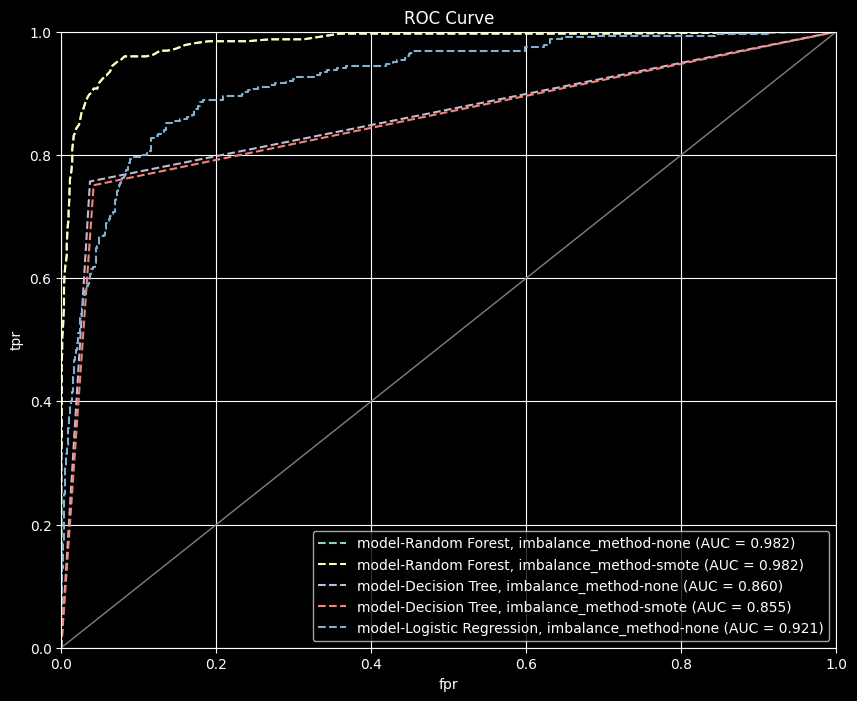

In [47]:
# 畫出排行前五名的圖
from sklearn.metrics import roc_curve, auc
_verbose = False
plt.style.use('dark_background')
plt.figure(figsize=(10, 8))
for index, model_res in pd_model_result_sorted.head(5).iterrows():
    _model = model_res['model']
    _imbalance_method = model_res['imbalance_method']
    # 資料不平衡處理
    imbalance_handler = DataImbalanceHandler(_X_train, _y_train, verbose=_verbose)
    X_train_res, y_train_res = imbalance_handler.handle_imbalance(method=_imbalance_method)
    print(f" Ater: {Counter(y_train_res)}") 

    # 模型訓練與評估
    _model_factory = ModelFactory(verbose=_verbose).create_and_train_model(_model, _X_train, _y_train)  # 創建 ModelFactory 實例
    print(_model_factory.__class__.__name__)
    model_results = ModelTraining(X_train_res, y_train_res, _X_test, _y_test, None, verbose=_verbose).evaluate(_model_factory)
    
    # 計算 ROC 曲線
    fpr, tpr, thresholds = roc_curve(_y_test, _model_factory.predict_proba(_X_test)[:, 1])  # 取概率的第二列
    roc_auc = auc(fpr, tpr)

    # 畫出 ROC 曲線
    plt.plot(fpr, tpr, linestyle="--", label=f"model-{_model}, imbalance_method-{_imbalance_method} (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="-", linewidth=1)
plt.legend(loc="lower right")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC Curve")
plt.grid(True)

plt.show()

---

##### ✅Overfit 參數調整結果 – RF 

In [23]:
results_rf_df = pd.read_csv(fr"{workspace}\model_result_rf_0510.csv")
_results_rf_df = results_rf_df.groupby(['max_depth', 'min_samples_split', 'min_samples_leaf']).agg({'test_accuracy': 'mean', 'test_f1': 'mean', 'train_accuracy': 'mean', 'train_f1': 'mean','cv_acc_mean': 'mean', 'cv_f1_mean': 'mean', 'elapsed_time':'mean'}).reset_index()
_results_rf_df[['test_accuracy', 'test_f1', 'train_accuracy', 'train_f1', 'cv_acc_mean', 'cv_f1_mean', 'elapsed_time']] = _results_rf_df[['test_accuracy', 'test_f1', 'train_accuracy', 'train_f1', 'cv_acc_mean', 'cv_f1_mean', 'elapsed_time']].round(3)

In [24]:
from tabulate import tabulate
print('調整random  forest參數')
_results_rf_df['f1_difference'] = abs(_results_rf_df['test_f1'] - _results_rf_df['train_f1']).round(3)
pd_rf_result_sorted = _results_rf_df.sort_values(by=['f1_difference', 'test_accuracy'], ascending=[True, False])
top_models = pd_rf_result_sorted.head(5)

print("test f1 & train f1差距最小 且 test accuracy 最大")
print(tabulate(top_models.reset_index(drop=True), headers='keys', tablefmt='pretty', showindex=False))


調整random  forest參數
test f1 & train f1差距最小 且 test accuracy 最大
+-----------+-------------------+------------------+---------------+---------+----------------+----------+-------------+------------+--------------+---------------+
| max_depth | min_samples_split | min_samples_leaf | test_accuracy | test_f1 | train_accuracy | train_f1 | cv_acc_mean | cv_f1_mean | elapsed_time | f1_difference |
+-----------+-------------------+------------------+---------------+---------+----------------+----------+-------------+------------+--------------+---------------+
|    5.0    |        2.0        |       2.0        |     0.91      |  0.627  |     0.916      |  0.672   |    0.913    |    0.66    |    17.194    |     0.045     |
|    5.0    |        3.0        |       2.0        |     0.91      |  0.627  |     0.916      |  0.672   |    0.913    |    0.66    |    17.29     |     0.045     |
|    5.0    |        4.0        |       2.0        |     0.91      |  0.627  |     0.916      |  0.672   |    0.91

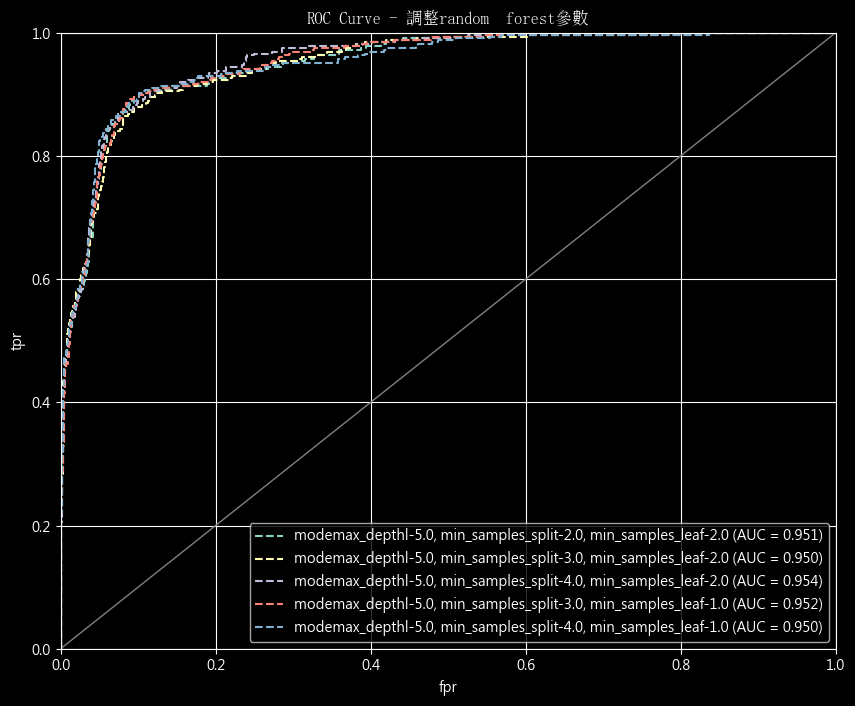

In [25]:
# 畫出排行前五名的圖
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
_verbose = False
plt.style.use('dark_background')
plt.figure(figsize=(10, 8))
for index, model_res in top_models.head(5).iterrows():
    _max_depth = model_res['max_depth']
    _min_samples_split = model_res['min_samples_split']
    _min_samples_leaf = model_res['min_samples_leaf']

    default_params = {
        'max_depth': int(_max_depth),
        'min_samples_split': int(_min_samples_split),
        'min_samples_leaf': int(_min_samples_leaf) 
    }
    model = RandomForestClassifier(**default_params)
    model.fit(_X_train, _y_train)
    
    # 計算 ROC 曲線
    fpr, tpr, thresholds = roc_curve(_y_test, model.predict_proba(_X_test)[:, 1])  # 取概率的第二列
    roc_auc = auc(fpr, tpr)

    # 畫出 ROC 曲線
    plt.plot(fpr, tpr, linestyle="--", label=f"modemax_depthl-{_max_depth}, min_samples_split-{_min_samples_split}, min_samples_leaf-{_min_samples_leaf} (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="-", linewidth=1)
plt.legend(loc="lower right")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC Curve - 調整random  forest參數", fontproperties=winfont01)
plt.grid(True)

plt.show()

---

##### ✅Overfit 參數調整結果 – 原始 & 調參後 RF

In [ ]:
from tabulate import tabulate
# 模型訓練與評估
_verbose = True
_model = 'Random Forest'
_model_factory = ModelFactory(verbose=_verbose).create_and_train_model(_model, _X_train, _y_train)  # 創建 ModelFactory 實例
print(_model_factory.__class__.__name__)

_max_depth = top_models.iloc[0]['max_depth']
_min_samples_split = top_models.iloc[0]['min_samples_split']
_min_samples_leaf = top_models.iloc[0]['min_samples_leaf']

default_params = {
    'max_depth': int(_max_depth),
    'min_samples_split': int(_min_samples_split),
    'min_samples_leaf': int(_min_samples_leaf) 
}
model = RandomForestClassifier(**default_params)
model.fit(_X_train, _y_train)
y_test_pred = model.predict(X_test)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
test_conf_matrix_df = pd.DataFrame(test_conf_matrix, index=['True 0', 'True 1'], columns=['Pred 0', 'Pred 1'])
print("==================================")
# 顯示混淆矩陣表格
print("Train Confusion Matrix:")
test_conf_matrix_df

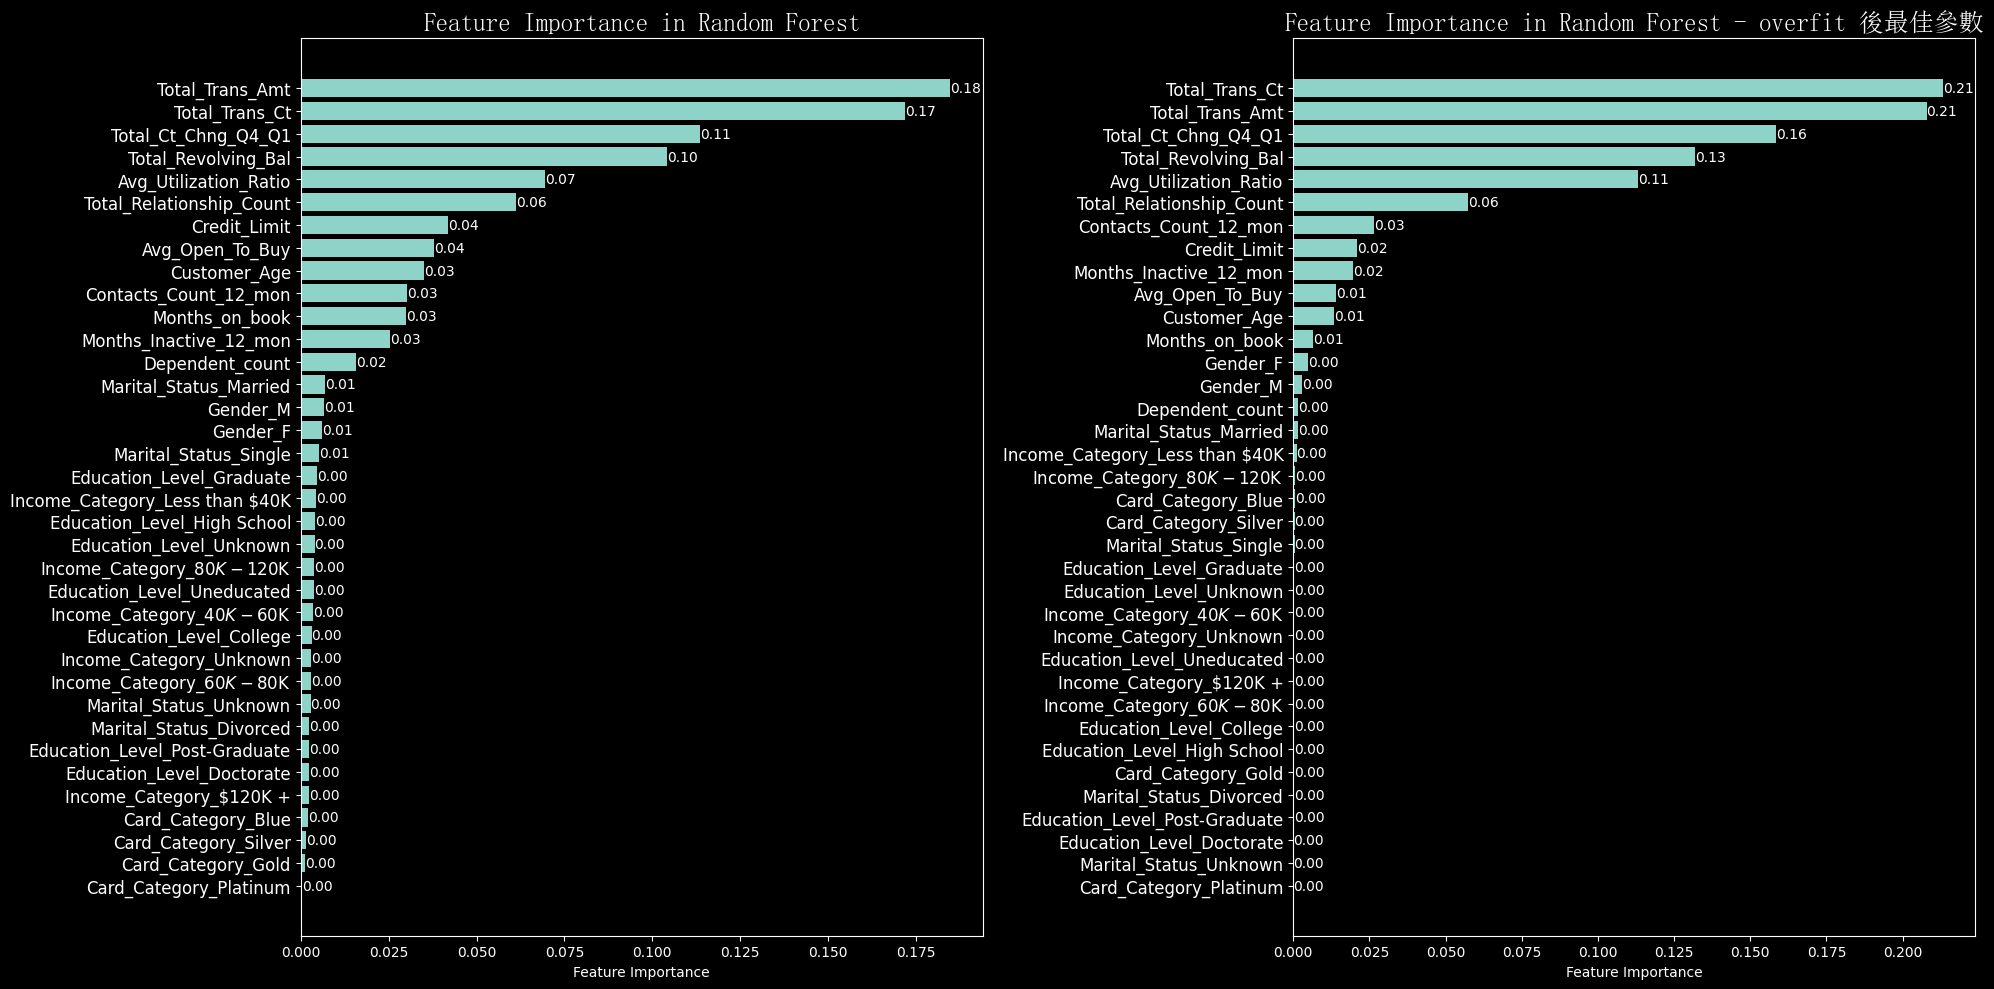

In [93]:
_verbose = False
_model = 'Random Forest'
_model_factory = ModelFactory(verbose=_verbose).create_and_train_model(_model, _X_train, _y_train)  # 創建 ModelFactory 實例

# 模型訓練與評估
model_results = ModelTraining(_X_train, _y_train, _X_test, _y_test, None, verbose=_verbose).evaluate(_model_factory)
feature_importances = _model_factory.feature_importances_

# 合併特徵名稱和對應的特徵重要性
features_df = pd.DataFrame({
    'feature': pd_X_std.columns,
    'importance': feature_importances
})
features_df = features_df.sort_values(by='importance', ascending=True).reset_index()   # 排序一下

# ============================
_max_depth = top_models.iloc[0]['max_depth']
_min_samples_split = top_models.iloc[0]['min_samples_split']
_min_samples_leaf = top_models.iloc[0]['min_samples_leaf']

default_params = {
    'max_depth': int(_max_depth),
    'min_samples_split': int(_min_samples_split),
    'min_samples_leaf': int(_min_samples_leaf) 
}

_model_factory_after_tuning = ModelFactory(verbose=_verbose).create_and_train_model(_model, _X_train, _y_train, **default_params)
feature_importances = _model_factory_after_tuning.feature_importances_

# 合併特徵名稱和對應的特徵重要性
features_df_after_tuning = pd.DataFrame({
    'feature': pd_X_std.columns,
    'importance': feature_importances
})
features_df_after_tuning = features_df_after_tuning.sort_values(by='importance', ascending=True).reset_index()   # 排序一下

# plot
plt.figure(figsize=[20, 10])
plt.subplot(1, 2, 1)
plt.barh(range(len(features_df)), features_df['importance'], align='center')
plt.yticks(range(len(features_df)), features_df['feature'], fontsize=12)  # X_train.columns 為特徵名稱
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Random Forest', fontproperties=winfont01, fontsize=18)
for index, value in enumerate(features_df['importance']):
    plt.text(value, index, f'{  value:.2f}', va='center', ha='left', fontsize=10)

# overfit 後最佳參數
plt.subplot(1, 2, 2)
plt.barh(range(len(features_df_after_tuning)), features_df_after_tuning['importance'], align='center')
plt.yticks(range(len(features_df_after_tuning)), features_df_after_tuning['feature'], fontsize=12)  # X_train.columns 為特徵名稱
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Random Forest - overfit 後最佳參數', fontproperties=winfont01, fontsize=18)
for index, value in enumerate(features_df_after_tuning['importance']):
    plt.text(value, index, f'{  value:.2f}', va='center', ha='left', fontsize=10)
plt.subplots_adjust(left=0.3)
plt.tight_layout()
plt.show()

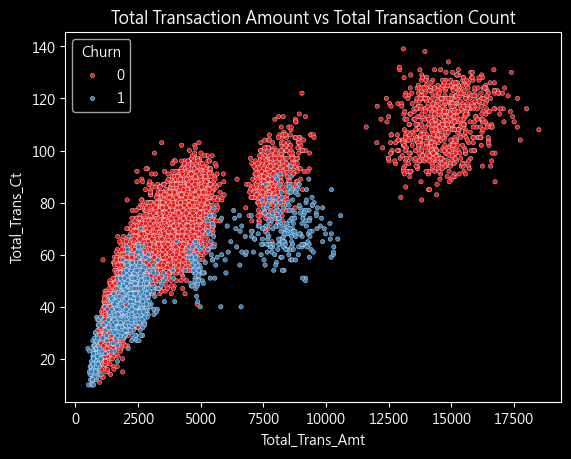

In [ ]:
sns.scatterplot(x=df['Total_Trans_Amt'], y=df['Total_Trans_Ct'], hue=df['Churn'], palette='Set1', s=10)
plt.title("Total Transaction Amount vs Total Transaction Count")  # 標題
plt.xlabel('Total_Trans_Amt')  # x 軸標籤
plt.ylabel('Total_Trans_Ct')  # y 軸標籤

plt.show()

---

##### ✅把需要的結果輸出

In [ ]:
with pd.ExcelWriter(fr"{workspace}\summary_model_result.xlsx", engine='openpyxl') as writer:
    pd_model_result_sorted.to_excel(writer, sheet_name='All Models Sorted by Accuracy and F1', index=False)
    top_models.to_excel(writer, sheet_name='Random Forest Hyperparameter Tuning', index=False)
    test_conf_matrix_df.to_excel(writer, sheet_name='test conf matrix df', index=True)
    df_classification_report.to_excel(writer, sheet_name='test classification report', index=True)

c:\Users\USER\.pyenv\pyenv-win\versions\3.10.5\lib\site-packages\openpyxl\workbook\child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")
